In [1]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline

Alleviating barren plateaus with local cost functions
=====================================================

::: {.meta}
:property=\"og:description\": Local cost functions are cost formulations
for variational quantum circuits that are more robust to barren
plateaus. :property=\"og:image\":
../demonstrations/local\_cost\_functions/Cerezo\_et\_al\_local\_cost\_functions.png
:::

::: {.related}
tutorial\_barren\_plateaus Barren plateaus in QNNs
:::

*Author: Thomas Storwick (tstorwick\@gmail.com). Posted: 9 Sep 2020.
Last updated: 28 Jan 2021.*

Barren Plateaus
---------------

`Barren plateaus </demos/tutorial_barren_plateaus>`{.interpreted-text
role="doc"} are large regions of the cost function\'s parameter space
where the variance of the gradient is almost 0; or, put another way, the
cost function landscape is flat. This means that a variational circuit
initialized in one of these areas will be untrainable using any
gradient-based algorithm.

In [\"Cost-Function-Dependent Barren Plateaus in Shallow Quantum Neural
Networks\"](https://arxiv.org/abs/2001.00550), Cerezo et al. demonstrate
the idea that the barren plateau phenomenon can, under some
circumstances, be avoided by using cost functions that only have
information from part of the circuit. These *local* cost functions can
be more robust against noise, and may have better-behaved gradients with
no plateaus for shallow circuits.

![Taken from Cerezo et
al..](../demonstrations/local_cost_functions/Cerezo_et_al_local_cost_functions.png){.align-center
width="50.0%"}

Many variational quantum algorithms are constructed to use global cost
functions. Information from the entire measurement is used to analyze
the result of the circuit, and a cost function is calculated from this
to quantify the circuit\'s performance. A local cost function only
considers information from a few qubits, and attempts to analyze the
behavior of the entire circuit from this limited scope.

Cerezo et al. also handily prove that these local cost functions are
bounded by the global ones, i.e., if a global cost function is
formulated in the manner described by Cerezo et al., then the value of
its corresponding local cost function will always be less than or equal
to the value of the global cost function.

In this notebook, we investigate the effect of barren plateaus in
variational quantum algorithms, and how they can be mitigated using
local cost functions.

We first need to import the following modules.


In [2]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import LinearLocator, FormatStrFormatter

np.random.seed(42)

Visualizing the problem
=======================

To start, let\'s look at the task of learning the identity gate across
multiple qubits. This will help us visualize the problem and get a sense
of what is happening in the cost landscape.

First we define a number of wires we want to train on. The work by
Cerezo et al. shows that circuits are trainable under certain regimes,
so how many qubits we train on will effect our results.


In [3]:
wires = 6
dev = qml.device("default.qubit", wires=wires, shots=10000)

Next, we want to define our QNodes and our circuit ansatz. For this
simple example, an ansatz that works well is simply a rotation along X,
and a rotation along Y, repeated across all the qubits.

We will also define our cost functions here. Since we are trying to
learn the identity gate, a natural cost function is 1 minus the
probability of measuring the zero state, denoted here as
$1 - p_{|0\rangle}$.

$$C = \langle  \psi(\theta) | \left(I - |0\rangle \langle 0|\right)  | \psi(\theta)  \rangle   =1-p_{|0\rangle}$$

We will apply this across all qubits for our global cost function, i.e.,

$$C_{G} = \langle  \psi(\theta) | \left(I - |00 \ldots 0\rangle \langle 00 \ldots 0|\right) | \psi(\theta) \rangle  = 1-p_{|00 \ldots 0\rangle}$$

and for the local cost function, we will sum the individual
contributions from each qubit:

$$C_L = \langle \psi(\theta) | \left(I - \frac{1}{n} \sum_j |0\rangle \langle 0|_j\right)|\psi(\theta)\rangle = 1 - \sum_j p_{|0\rangle_j}.$$

It might be clear to some readers now why this function can perform
better. By formatting our local cost function in this way, we have
essentially divided the problem up into multiple single-qubit terms, and
summed all the results up.

To implement this, we will define a separate QNode for the local cost
function and the global cost function.


In [4]:
def global_cost_simple(rotations):
    for i in range(wires):
        qml.RX(rotations[0][i], wires=i)
        qml.RY(rotations[1][i], wires=i)
    return qml.probs(wires=range(wires))        # no entanglement in the circuit?

def local_cost_simple(rotations):
    for i in range(wires):
        qml.RX(rotations[0][i], wires=i)
        qml.RY(rotations[1][i], wires=i)
    return [qml.probs(wires=i) for i in range(wires)]

global_circuit = qml.QNode(global_cost_simple, dev)

local_circuit = qml.QNode(local_cost_simple, dev)

def cost_local(rotations):
    return 1 - np.sum(local_circuit(rotations)[:,0])/wires


def cost_global(rotations):
    return 1 - global_circuit(rotations)[0]

To analyze each of the circuits, we provide some random initial
parameters for each rotation.


In [5]:
RX = np.random.uniform(low=-np.pi, high=np.pi)
RY = np.random.uniform(low=-np.pi, high=np.pi)
rotations = [[RX for i in range(wires)], [RY for i in range(wires)]]

Examining the results:


Global Cost:  0.9999000
Local Cost:  0.8373000


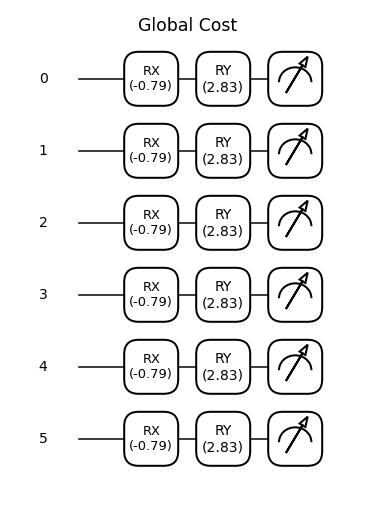

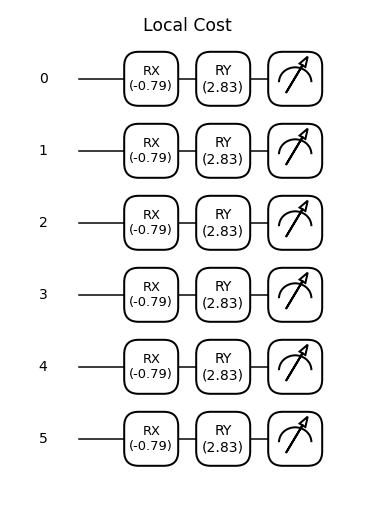

In [6]:
print("Global Cost: {: .7f}".format(cost_global(rotations)))
print("Local Cost: {: .7f}".format(cost_local(rotations)))

qml.drawer.use_style('black_white')
fig1, ax1 = qml.draw_mpl(global_circuit, decimals=2)(rotations)
fig1.suptitle("Global Cost", fontsize='xx-large')
plt.show()

fig2, ax2 = qml.draw_mpl(local_circuit, decimals=2)(rotations)
fig2.suptitle("Local Cost", fontsize='xx-large')
plt.show()

With this simple example, we can visualize the cost function, and see
the barren plateau effect graphically. Although there are $2n$ (where
$n$ is the number of qubits) parameters, in order to plot the cost
landscape we must constrain ourselves. We will consider the case where
all X rotations have the same value, and all the Y rotations have the
same value.

Firstly, we look at the global cost function. When plotting the cost
function across 6 qubits, much of the cost landscape is flat, and
difficult to train (even with a circuit depth of only 2!). This effect
will worsen as the number of qubits increases.


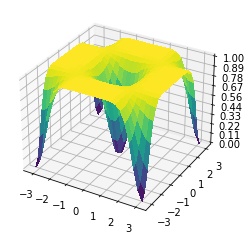

In [7]:
def generate_surface(cost_function):
    Z = []
    Z_assembler = []

    X = np.arange(-np.pi, np.pi, 0.25)
    Y = np.arange(-np.pi, np.pi, 0.25)
    X, Y = np.meshgrid(X, Y)

    for x in X[0, :]:
        for y in Y[:, 0]:
            rotations = [[x for i in range(wires)], [y for i in range(wires)]]
            Z_assembler.append(cost_function(rotations))
        Z.append(Z_assembler)
        Z_assembler = []

    Z = np.asarray(Z)
    return Z

def plot_surface(surface):
    X = np.arange(-np.pi, np.pi, 0.25)
    Y = np.arange(-np.pi, np.pi, 0.25)
    X, Y = np.meshgrid(X, Y)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    surf = ax.plot_surface(X, Y, surface, cmap="viridis", linewidth=0, antialiased=False)
    ax.set_zlim(0, 1)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter("%.02f"))
    plt.show()


global_surface = generate_surface(cost_global)
plot_surface(global_surface)

However, when we change to the local cost function, the cost landscape
becomes much more trainable as the size of the barren plateau decreases.


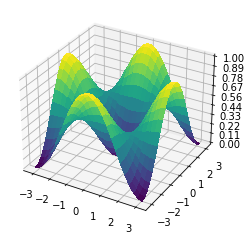

In [8]:
local_surface = generate_surface(cost_local)
plot_surface(local_surface)

Those are some nice pictures, but how do they reflect actual
trainability? Let us try training both the local and global cost
functions. To simplify this model, let\'s modify our cost function from

$$C_{L} = 1-\sum p_{|0\rangle},$$

where we sum the marginal probabilities of each qubit, to

$$C_{L} = 1-p_{|0\rangle},$$

where we only consider the probability of a single qubit to be in the 0
state.

While we\'re at it, let us make our ansatz a little more like one we
would encounter while trying to solve a VQE problem, and add
entanglement.


In [9]:
def global_cost_simple(rotations):
    for i in range(wires):
        qml.RX(rotations[0][i], wires=i)
        qml.RY(rotations[1][i], wires=i)
    qml.broadcast(qml.CNOT, wires=range(wires), pattern="chain")
    return qml.probs(wires=range(wires))
def local_cost_simple(rotations):
    for i in range(wires):
        qml.RX(rotations[0][i], wires=i)
        qml.RY(rotations[1][i], wires=i)
    qml.broadcast(qml.CNOT, wires=range(wires), pattern="chain")
    return qml.probs(wires=[0])

global_circuit = qml.QNode(global_cost_simple, dev)

local_circuit = qml.QNode(local_cost_simple, dev)

def cost_local(rotations):
    return 1 - local_circuit(rotations)[0]
def cost_global(rotations):
    return 1 - global_circuit(rotations)[0]

Of course, now that we\'ve changed both our cost function and our
circuit, we will need to scan the cost landscape again.


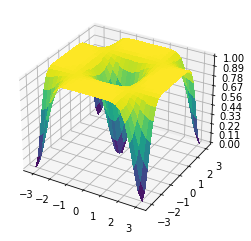

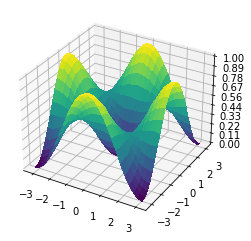

In [10]:
global_surface = generate_surface(cost_global)
plot_surface(global_surface)

local_surface = generate_surface(cost_local)
plot_surface(local_surface)

It seems our changes didn\'t significantly alter the overall cost
landscape. This probably isn\'t a general trend, but it is a nice
surprise. Now, let us get back to training the local and global cost
functions. Because we have a visualization of the total cost landscape,
let\'s pick a point to exaggerate the problem. One of the worst points
in the landscape is $(\pi,0)$ as it is in the middle of the plateau, so
let\'s use that.


Cost after step     5:  1.0000000
Cost after step    10:  1.0000000
Cost after step    15:  1.0000000
Cost after step    20:  1.0000000
Cost after step    25:  1.0000000
Cost after step    30:  1.0000000
Cost after step    35:  1.0000000
Cost after step    40:  1.0000000
Cost after step    45:  1.0000000
Cost after step    50:  1.0000000
Cost after step    55:  1.0000000
Cost after step    60:  1.0000000
Cost after step    65:  1.0000000
Cost after step    70:  1.0000000
Cost after step    75:  1.0000000
Cost after step    80:  1.0000000
Cost after step    85:  1.0000000
Cost after step    90:  1.0000000
Cost after step    95:  1.0000000
Cost after step   100:  1.0000000


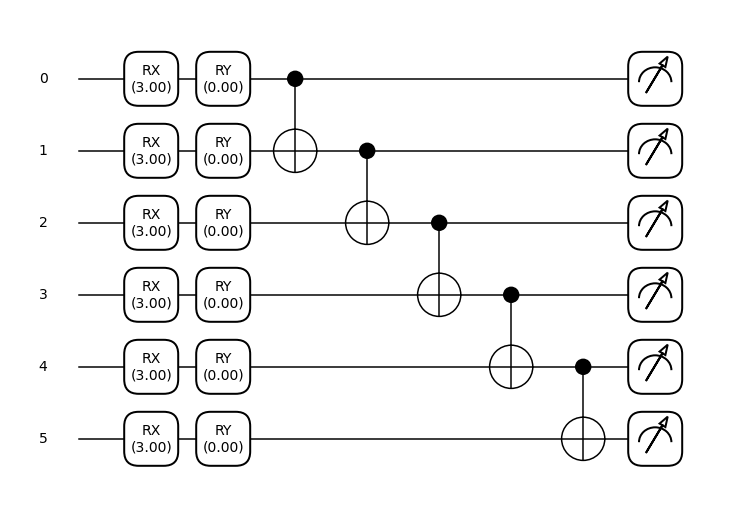

In [11]:
rotations = np.array([[3.] * len(range(wires)), [0.] * len(range(wires))], requires_grad=True)
opt = qml.GradientDescentOptimizer(stepsize=0.2)
steps = 100
params_global = rotations
for i in range(steps):
    # update the circuit parameters
    params_global = opt.step(cost_global, params_global)

    if (i + 1) % 5 == 0:
        print("Cost after step {:5d}: {: .7f}".format(i + 1, cost_global(params_global)))
    if cost_global(params_global) < 0.1:
        break
fig, ax = qml.draw_mpl(global_circuit, decimals=2)(params_global)
plt.show()

After 100 steps, the cost function is still exactly 1. Clearly we are in
an \"untrainable\" area. Now, let us limit ourselves to the local cost
function and see how it performs.


Cost after step     5:  0.9871000
Cost after step    10:  0.9651000
Cost after step    15:  0.9173000
Cost after step    20:  0.8059000
Cost after step    25:  0.6213000
Cost after step    30:  0.3703000
Cost after step    35:  0.1821000
Cost after step    40:  0.0684000


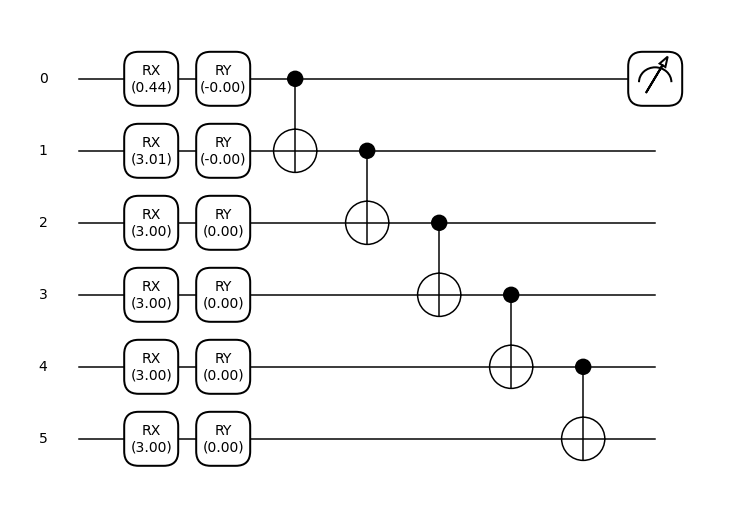

In [12]:
rotations = np.array([[3. for i in range(wires)], [0. for i in range(wires)]], requires_grad=True)
opt = qml.GradientDescentOptimizer(stepsize=0.2)
steps = 100
params_local = rotations
for i in range(steps):
    # update the circuit parameters
    params_local = opt.step(cost_local, params_local)

    if (i + 1) % 5 == 0:
        print("Cost after step {:5d}: {: .7f}".format(i + 1, cost_local(params_local)))
    if cost_local(params_local) < 0.05:
        break

fig, ax = qml.draw_mpl(local_circuit, decimals=2)(params_local)
plt.show()

It trained! And much faster than the global case. However, we know our
local cost function is bounded by the global one, but just how much have
we trained it?


In [13]:
cost_global(params_local)

tensor(1., requires_grad=True)

Interestingly, the global cost function is still 1. If we trained the
local cost function, why hasn\'t the global cost function changed?

The answer is that we have trained the global cost a *little bit*, but
not enough to see a change with only 10000 shots. To see the effect,
we\'ll need to increase the number of shots to an unreasonable amount.
Instead, making the backend analytic by setting shots to `None`, gives
us the exact representation.


In [14]:
dev.shots = None
global_circuit = qml.QNode(global_cost_simple, dev)
print(
    "Current cost: "
    + str(cost_global(params_local))
    + ".\nInitial cost: "
    + str(cost_global([[3.0 for i in range(wires)], [0 for i in range(wires)]]))
    + ".\nDifference: "
    + str(
        cost_global([[3.0 for i in range(wires)], [0 for i in range(wires)]])
        - cost_global(params_local)
    )
)

Current cost: 0.9999999999972213.
Initial cost: 0.9999999999999843.
Difference: 2.763012041384627e-12


Our circuit has definitely been trained, but not a useful amount. If we
attempt to use this circuit, it would act the same as if we never
trained at all. Furthermore, if we now attempt to train the global cost
function, we are still firmly in the plateau region. In order to fully
train the global circuit, we will need to increase the locality
gradually as we train.


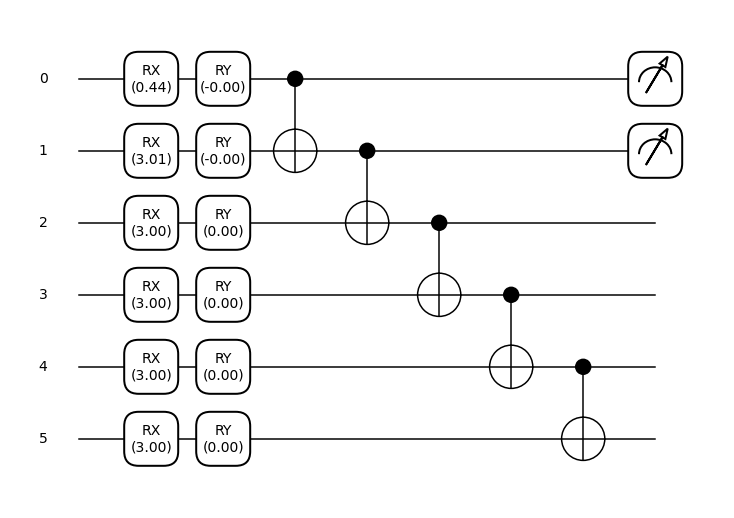

0.9957
Cost after step    10:  0.9909000. Locality: 2
Cost after step    20:  0.9753000. Locality: 2
Cost after step    30:  0.9275000. Locality: 2
Cost after step    40:  0.8386000. Locality: 2
Cost after step    50:  0.6821000. Locality: 2
Cost after step    60:  0.4353000. Locality: 2
Cost after step    70:  0.2264000. Locality: 2
Cost after step    80:  0.0923000. Locality: 2
---Switching Locality---
Cost after step    90:  0.9901000. Locality: 3
Cost after step   100:  0.9737000. Locality: 3
Cost after step   110:  0.9400000. Locality: 3
Cost after step   120:  0.8711000. Locality: 3
Cost after step   130:  0.7228000. Locality: 3
Cost after step   140:  0.5156000. Locality: 3
Cost after step   150:  0.2846000. Locality: 3
Cost after step   160:  0.1285000. Locality: 3
---Switching Locality---
Cost after step   170:  0.9899000. Locality: 4
Cost after step   180:  0.9799000. Locality: 4
Cost after step   190:  0.9512000. Locality: 4
Cost after step   200:  0.8964000. Locality: 4
Cos

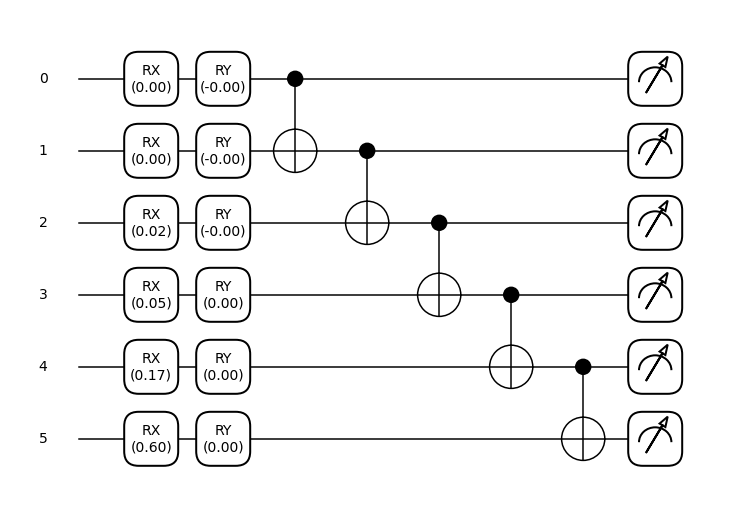

In [15]:
def tunable_cost_simple(rotations):
    for i in range(wires):
        qml.RX(rotations[0][i], wires=i)
        qml.RY(rotations[1][i], wires=i)
    qml.broadcast(qml.CNOT, wires=range(wires), pattern="chain")
    return qml.probs(range(locality))

def cost_tunable(rotations):
    return 1 - tunable_circuit(rotations)[0]

dev.shots = 10000
tunable_circuit = qml.QNode(tunable_cost_simple, dev)
locality = 2
params_tunable = params_local
fig, ax = qml.draw_mpl(tunable_circuit, decimals=2)(params_tunable)
plt.show()
print(cost_tunable(params_tunable))

locality = 2
opt = qml.GradientDescentOptimizer(stepsize=0.1)
steps = 600
for i in range(steps):
    # update the circuit parameters
    params_tunable = opt.step(cost_tunable, params_tunable)

    runCost = cost_tunable(params_tunable)
    if (i + 1) % 10 == 0:
        print(
            "Cost after step {:5d}: {: .7f}".format(i + 1, runCost)
            + ". Locality: "
            + str(locality)
        )

    if runCost < 0.1 and locality < wires:
        print("---Switching Locality---")
        locality += 1
        continue
    elif runCost < 0.1 and locality >= wires:
        break
fig, ax = qml.draw_mpl(tunable_circuit, decimals=2)(params_tunable)
plt.show()

A more thorough analysis
========================

Now the circuit can be trained, even though we started from a place
where the global function has a barren plateau. The significance of this
is that we can now train from every starting location in this example.

But, how often does this problem occur? If we wanted to train this
circuit from a random starting point, how often would we be stuck in a
plateau? To investigate this, let\'s attempt to train the global cost
function using random starting positions and count how many times we run
into a barren plateau.

Let\'s use a number of qubits we are more likely to use in a real
variational circuit: n=10. We will say that after 400 steps, any run
with a cost function of less than 0.9 (chosen arbitrarily) will probably
be trainable given more time. Any run with a greater cost function will
probably be in a plateau.

This may take up to 15 minutes.


In [16]:
samples = 10
plateau = 0
trained = 0
opt = qml.GradientDescentOptimizer(stepsize=0.2)
steps = 400
wires = 8

dev = qml.device("default.qubit", wires=wires, shots=10000)
global_circuit = qml.QNode(global_cost_simple, dev)

for runs in range(samples):
    print("--- New run! ---")
    has_been_trained = False

    params_global = np.random.uniform(-np.pi, np.pi, (2, wires), requires_grad=True)

    for i in range(steps):
        # update the circuit parameters
        params_global = opt.step(cost_global, params_global)

        if (i + 1) % 20 == 0:
            print("Cost after step {:5d}: {: .7f}".format(i + 1, cost_global(params_global)))
        if cost_global(params_global) < 0.9:
            has_been_trained = True
            break
    if has_been_trained:
        trained = trained + 1
    else:
        plateau = plateau + 1
    print("Trained: {:5d}".format(trained))
    print("Plateau'd: {:5d}".format(plateau))


samples = 10
plateau = 0
trained = 0
opt = qml.GradientDescentOptimizer(stepsize=0.2)
steps = 400
wires = 8

dev = qml.device("default.qubit", wires=wires, shots=10000)
tunable_circuit = qml.QNode(tunable_cost_simple, dev)

for runs in range(samples):
    locality = 1
    print("--- New run! ---")
    has_been_trained = False

    params_tunable = np.random.uniform(-np.pi, np.pi, (2, wires), requires_grad=True)
    for i in range(steps):
        # update the circuit parameters
        params_tunable = opt.step(cost_tunable, params_tunable)

        runCost = cost_tunable(params_tunable)
        if (i + 1) % 10 == 0:
            print(
                "Cost after step {:5d}: {: .7f}".format(i + 1, runCost)
                + ". Locality: "
                + str(locality)
            )

        if runCost < 0.5 and locality < wires:
            print("---Switching Locality---")
            locality += 1
            continue
        elif runCost < 0.1 and locality >= wires:
            trained = trained + 1
            has_been_trained = True
            break
    if not has_been_trained:
        plateau = plateau + 1
    print("Trained: {:5d}".format(trained))
    print("Plateau'd: {:5d}".format(plateau))

--- New run! ---
Cost after step    20:  1.0000000
Cost after step    40:  1.0000000
Cost after step    60:  1.0000000
Cost after step    80:  1.0000000
Cost after step   100:  1.0000000
Cost after step   120:  1.0000000
Cost after step   140:  1.0000000
Cost after step   160:  1.0000000
Cost after step   180:  1.0000000
Cost after step   200:  1.0000000
Cost after step   220:  1.0000000
Cost after step   240:  1.0000000
Cost after step   260:  1.0000000
Cost after step   280:  1.0000000
Cost after step   300:  1.0000000
Cost after step   320:  1.0000000
Cost after step   340:  1.0000000
Cost after step   360:  1.0000000
Cost after step   380:  1.0000000
Cost after step   400:  1.0000000
Trained:     0
Plateau'd:     1
--- New run! ---
Cost after step    20:  0.9993000
Cost after step    40:  0.9994000
Cost after step    60:  0.9995000
Cost after step    80:  0.9994000
Cost after step   100:  0.9996000
Cost after step   120:  0.9995000
Cost after step   140:  0.9986000
Cost after step 

KeyboardInterrupt: 

In the global case, anywhere between 70-80% of starting positions are
untrainable, a significant number. It is likely that, as the complexity
of our ansatz---and the number of qubits---increases, this factor will
increase.

We can compare that to our local cost function, where every single area
trained, and most even trained in less time. While these examples are
simple, this local-vs-global cost behaviour has been shown to extend to
more complex problems.


References
==========
